# Load the pymoo result object saved with pickle.
ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [49]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

## Load result object
Place a pymoo result object file saved with pickle and execute the following cell.
Replace 'res_Cogent.pkl' with your result file saved with pickle.

In [50]:
# with open('res_bc_Cogent_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_UsCarrier_agemoea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_HiberniaGlobal_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Colt_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Funet_agemoea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Abvt_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Intellifiber_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_TataNld_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Kdl_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Internode_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Missouri_agemoea.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Ion_agemoea.pkl','rb') as f:
#     res = pickle.load(f)
with open('res_bc_Palmetto_agemoea.pkl','rb') as f:
    res = pickle.load(f)

## Show all optimal solutions

In [51]:
F = res.F
print(F[np.argsort(F[:, 0])])

[[2.00000000e+00 3.00000000e+00 1.64421659e+02 4.44467670e-01]
 [2.00000000e+00 4.00000000e+00 1.48897895e+02 4.46217247e-01]
 [2.00000000e+00 3.00000000e+00 2.21420587e+02 4.44467384e-01]
 [2.00000000e+00 4.00000000e+00 2.19769780e+02 4.44467384e-01]
 [3.00000000e+00 6.00000000e+00 1.53593375e+02 2.89522682e-01]
 [3.00000000e+00 4.00000000e+00 1.58424930e+02 2.89522682e-01]
 [3.00000000e+00 3.00000000e+00 1.94991295e+02 2.89427738e-01]
 [3.00000000e+00 3.00000000e+00 1.47660436e+02 2.89528590e-01]
 [3.00000000e+00 3.00000000e+00 1.20850689e+02 2.90870397e-01]
 [4.00000000e+00 4.00000000e+00 1.08859850e+02 2.16047272e-01]
 [4.00000000e+00 3.00000000e+00 1.12537428e+02 2.12777643e-01]
 [4.00000000e+00 3.00000000e+00 1.05941785e+02 2.23212820e-01]
 [5.00000000e+00 3.00000000e+00 1.31431391e+02 1.65702478e-01]
 [5.00000000e+00 3.00000000e+00 1.10621468e+02 1.66081062e-01]
 [5.00000000e+00 4.00000000e+00 1.24620862e+02 1.65690430e-01]
 [5.00000000e+00 3.00000000e+00 9.58116286e+01 1.733127

## Find the best case and the worst Case in the result set.

Ideal point:  [2.00000000e+00 3.00000000e+00 6.61030104e+01 8.42905792e-03]
Nadir point:  [ 43.           9.         221.42058684   0.44621725]


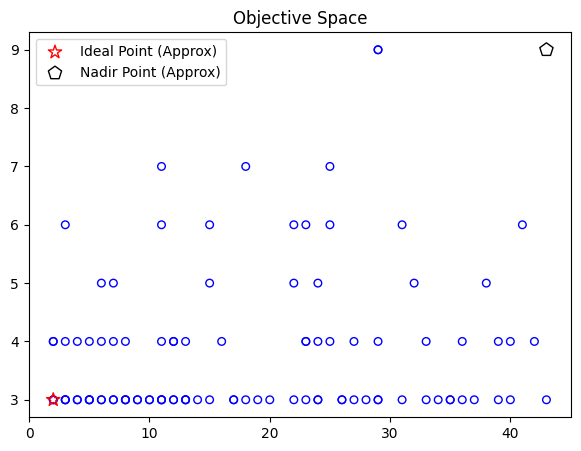

In [52]:
import matplotlib.pyplot as plt

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

print("Ideal point: ", approx_ideal)
print("Nadir point: ", approx_nadir)

with open('ips_of_all_9_algos.txt', 'a', encoding='utf-8') as f:
    f.write('AGEMOEA: ' + str(approx_ideal))
    f.write('\n')

with open('nps_of_all_9_algos.txt', 'a', encoding='utf-8') as f1:
    f1.write('AGEMOEA: ' + str(approx_nadir))
    f1.write('\n')

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()